# Churn Prediction Enhancement (Phase 4.1)

**Author:** Harpinder Singh  
**Objective:** Improve model performance through advanced techniques

**Previous Results:** ROC-AUC 0.64 (Random Forest)  
**Target:** ROC-AUC >0.75

---

## Improvements Applied:
1. **SMOTE oversampling** - Synthetic minority samples
2. **Polynomial/interaction features** - Capture non-linear relationships
3. **Feature selection** - Remove noise
4. **Ensemble stacking** - Combine model strengths
5. **Optimized hyperparameters** - More aggressive tuning

---

## 1. Environment Setup

╔════════════════════════════════════════════════════════════════╗
║                    ENVIRONMENT CONFIGURATION                    ║
╚════════════════════════════════════════════════════════════════╝

In [1]:
import warnings
from pathlib import Path
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, precision_recall_curve
)

# Handle class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Models
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import pickle

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Environment configured with imbalanced-learn")

✅ Environment configured with imbalanced-learn


In [2]:
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent

DIR_DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
DIR_MODELS = PROJECT_ROOT / 'models'
DIR_RESULTS = PROJECT_ROOT / 'results'
DIR_FIGURES = PROJECT_ROOT / 'results' / 'figures'

for directory in [DIR_MODELS, DIR_RESULTS, DIR_FIGURES]:
    directory.mkdir(parents=True, exist_ok=True)

print("✅ Directories ready")

✅ Directories ready


---

## 2. Load Data

╔════════════════════════════════════════════════════════════════╗
║                      DATA LOADING                               ║
╚════════════════════════════════════════════════════════════════╝

In [3]:
data = pd.read_csv(DIR_DATA_PROCESSED / 'churn_features.csv')

X = data.drop(['CustomerID', 'churned'], axis=1)
y = data['churned']

print(f"Dataset: {X.shape}")
print(f"Churn rate: {y.mean()*100:.1f}%")
print(f"\nClass distribution:")
print(y.value_counts())

Dataset: (815, 30)
Churn rate: 26.9%

Class distribution:
churned
0    596
1    219
Name: count, dtype: int64


---

## 3. Feature Engineering v2.0

╔════════════════════════════════════════════════════════════════╗
║              ADVANCED FEATURE ENGINEERING                       ║
╚════════════════════════════════════════════════════════════════╝

### Strategy:
1. **Interaction features** - RFM combinations
2. **Polynomial features** - Top 10 features only
3. **Feature selection** - Remove noise

In [4]:
# ┌────────────────────────────────────────────────────────────┐
# │ Create Interaction Features                               │
# └────────────────────────────────────────────────────────────┘

print("Creating interaction features...\n")

X_enhanced = X.copy()

# RFM interactions
X_enhanced['RFM_score'] = X['Recency'] * X['Frequency'] * X['Monetary']
X_enhanced['RF_ratio'] = X['Recency'] / (X['Frequency'] + 1)
X_enhanced['FM_ratio'] = X['Frequency'] * X['Monetary']
X_enhanced['RM_ratio'] = X['Recency'] / (X['Monetary'] + 1)

# Probabilistic interactions
X_enhanced['alive_clv_interaction'] = X['prob_alive'] * X['CLV_365d']
X_enhanced['alive_frequency'] = X['prob_alive'] * X['Frequency']
X_enhanced['alive_monetary'] = X['prob_alive'] * X['Monetary']

# Velocity interactions
X_enhanced['revenue_quantity_velocity'] = X['revenue_velocity'] * X['quantity_velocity']
X_enhanced['velocity_combined'] = (X['revenue_velocity'] + X['quantity_velocity']) / 2

# Behavioral patterns
X_enhanced['purchase_efficiency'] = X['Monetary'] / (X['purchase_gap_mean'] + 1)
X_enhanced['product_engagement'] = X['unique_products'] * X['Frequency']
X_enhanced['basket_monetary'] = X['AvgBasketSize'] * X['AvgOrderValue']

# Temporal-monetary
X_enhanced['tenure_monetary'] = X['Tenure'] * X['Monetary']
X_enhanced['tenure_frequency'] = X['Tenure'] * X['Frequency']

print(f"Features before: {X.shape[1]}")
print(f"Features after interactions: {X_enhanced.shape[1]}")
print(f"New features added: {X_enhanced.shape[1] - X.shape[1]}")

Creating interaction features...

Features before: 30
Features after interactions: 44
New features added: 14


In [5]:
# ┌────────────────────────────────────────────────────────────┐
# │ Feature Selection - Remove Low-Importance Features        │
# └────────────────────────────────────────────────────────────┘

# Use SelectKBest to identify most predictive features
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_enhanced, y)

# Get feature scores
feature_scores = pd.DataFrame({
    'feature': X_enhanced.columns,
    'score': selector.scores_
}).sort_values('score', ascending=False)

print("Top 20 Features by F-statistic:")
print("="*80)
print(feature_scores.head(20).to_string(index=False))

# Keep top 40 features (balance between information and noise)
top_features = feature_scores.head(40)['feature'].tolist()
X_selected = X_enhanced[top_features]

print(f"\nFeatures selected: {len(top_features)}")
print(f"Features removed: {X_enhanced.shape[1] - len(top_features)}")

Top 20 Features by F-statistic:
                 feature   score
                RF_ratio 49.5935
     purchase_regularity 41.9065
                RM_ratio 40.0397
         purchase_gap_cv 39.3920
                  Tenure 39.0445
predicted_purchases_180d 37.1949
 predicted_purchases_90d 37.1949
 predicted_purchases_30d 37.1949
   day_of_week_diversity 35.0603
                 Recency 28.9261
        purchase_gap_std 27.8206
                 CLV_90d 14.0199
                CLV_180d 14.0199
                CLV_365d 14.0199
   alive_clv_interaction 14.0199
 product_diversity_ratio 12.8104
          alive_monetary 12.5261
                Monetary 12.5261
        tenure_frequency 11.6813
       purchase_gap_mean 11.0774

Features selected: 40
Features removed: 4


---

## 4. Train-Test Split with SMOTE

╔════════════════════════════════════════════════════════════════╗
║                   SMOTE OVERSAMPLING                            ║
╚════════════════════════════════════════════════════════════════╝

In [6]:
# Split first
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y,
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Original Training Distribution:")
print(f"  Active: {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train)*100:.1f}%)")
print(f"  Churned: {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.1f}%)")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=3)  # k=3 for small dataset
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("\nAfter SMOTE:")
print(f"  Active: {(y_train_resampled == 0).sum()} ({(y_train_resampled == 0).sum()/len(y_train_resampled)*100:.1f}%)")
print(f"  Churned: {(y_train_resampled == 1).sum()} ({(y_train_resampled == 1).sum()/len(y_train_resampled)*100:.1f}%)")
print(f"  Total samples: {len(y_train)} → {len(y_train_resampled)}")

print("\n✅ SMOTE applied - Perfect class balance achieved")

Original Training Distribution:
  Active: 417 (73.2%)
  Churned: 153 (26.8%)

After SMOTE:
  Active: 417 (50.0%)
  Churned: 417 (50.0%)
  Total samples: 570 → 834

✅ SMOTE applied - Perfect class balance achieved


---

## 5. Enhanced Models with Better Hyperparameters

╔════════════════════════════════════════════════════════════════╗
║                  OPTIMIZED MODELS                               ║
╚════════════════════════════════════════════════════════════════╝

In [7]:
def evaluate_model_v2(model, X_train, X_test, y_train, y_test, model_name):
    """Enhanced evaluation function."""
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Cross-validation on training set
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')
    
    results = {
        'model_name': model_name,
        'model': model,
        'train_time': train_time,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'cv_roc_auc_mean': cv_scores.mean(),
        'cv_roc_auc_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    return results

print("✅ Enhanced evaluation function ready")

✅ Enhanced evaluation function ready


In [8]:
# ┌────────────────────────────────────────────────────────────┐
# │ Model 1: Random Forest (Optimized)                        │
# └────────────────────────────────────────────────────────────┘

print("Training optimized Random Forest...\n")

rf_model = RandomForestClassifier(
    n_estimators=300,  # More trees
    max_depth=15,      # Deeper trees
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_results = evaluate_model_v2(
    rf_model, X_train_resampled, X_test_scaled, y_train_resampled, y_test,
    'Random Forest (Enhanced)'
)

print("✅ Random Forest Results:")
print(f"   ROC-AUC: {rf_results['roc_auc']:.4f}")
print(f"   CV ROC-AUC: {rf_results['cv_roc_auc_mean']:.4f} ± {rf_results['cv_roc_auc_std']:.4f}")
print(f"   Precision: {rf_results['precision']:.4f}")
print(f"   Recall: {rf_results['recall']:.4f}")
print(f"   F1-Score: {rf_results['f1']:.4f}")

Training optimized Random Forest...

✅ Random Forest Results:
   ROC-AUC: 0.6030
   CV ROC-AUC: 0.8735 ± 0.0158
   Precision: 0.3333
   Recall: 0.3333
   F1-Score: 0.3333


In [9]:
# ┌────────────────────────────────────────────────────────────┐
# │ Model 2: LightGBM (Optimized)                             │
# └────────────────────────────────────────────────────────────┘

print("Training optimized LightGBM...\n")

lgbm_model = LGBMClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    num_leaves=50,
    min_child_samples=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    verbose=-1
)

lgbm_results = evaluate_model_v2(
    lgbm_model, X_train_resampled, X_test_scaled, y_train_resampled, y_test,
    'LightGBM (Enhanced)'
)

print("✅ LightGBM Results:")
print(f"   ROC-AUC: {lgbm_results['roc_auc']:.4f}")
print(f"   CV ROC-AUC: {lgbm_results['cv_roc_auc_mean']:.4f} ± {lgbm_results['cv_roc_auc_std']:.4f}")
print(f"   Precision: {lgbm_results['precision']:.4f}")
print(f"   Recall: {lgbm_results['recall']:.4f}")
print(f"   F1-Score: {lgbm_results['f1']:.4f}")

Training optimized LightGBM...

✅ LightGBM Results:
   ROC-AUC: 0.6043
   CV ROC-AUC: 0.8706 ± 0.0142
   Precision: 0.3448
   Recall: 0.3030
   F1-Score: 0.3226


In [10]:
# ┌────────────────────────────────────────────────────────────┐
# │ Model 3: XGBoost (Optimized)                              │
# └────────────────────────────────────────────────────────────┘

print("Training optimized XGBoost...\n")

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    random_state=RANDOM_STATE,
    eval_metric='logloss'
)

xgb_results = evaluate_model_v2(
    xgb_model, X_train_resampled, X_test_scaled, y_train_resampled, y_test,
    'XGBoost (Enhanced)'
)

print("✅ XGBoost Results:")
print(f"   ROC-AUC: {xgb_results['roc_auc']:.4f}")
print(f"   CV ROC-AUC: {xgb_results['cv_roc_auc_mean']:.4f} ± {xgb_results['cv_roc_auc_std']:.4f}")
print(f"   Precision: {xgb_results['precision']:.4f}")
print(f"   Recall: {xgb_results['recall']:.4f}")
print(f"   F1-Score: {xgb_results['f1']:.4f}")

Training optimized XGBoost...

✅ XGBoost Results:
   ROC-AUC: 0.5963
   CV ROC-AUC: 0.8723 ± 0.0183
   Precision: 0.3158
   Recall: 0.2727
   F1-Score: 0.2927


---

## 6. Ensemble Stacking

╔════════════════════════════════════════════════════════════════╗
║                  ENSEMBLE STACKING                              ║
╚════════════════════════════════════════════════════════════════╝

### Strategy:
Combine predictions from multiple models using meta-learner

In [11]:
# ┌────────────────────────────────────────────────────────────┐
# │ Stacking Classifier                                        │
# └────────────────────────────────────────────────────────────┘

print("Building stacking ensemble...\n")

# Base models
base_models = [
    ('rf', rf_model),
    ('lgbm', lgbm_model),
    ('xgb', xgb_model)
]

# Meta-learner
meta_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

# Stacking
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=3
)

stacking_results = evaluate_model_v2(
    stacking_model, X_train_resampled, X_test_scaled, y_train_resampled, y_test,
    'Stacking Ensemble'
)

print("✅ Stacking Ensemble Results:")
print(f"   ROC-AUC: {stacking_results['roc_auc']:.4f}")
print(f"   CV ROC-AUC: {stacking_results['cv_roc_auc_mean']:.4f} ± {stacking_results['cv_roc_auc_std']:.4f}")
print(f"   Precision: {stacking_results['precision']:.4f}")
print(f"   Recall: {stacking_results['recall']:.4f}")
print(f"   F1-Score: {stacking_results['f1']:.4f}")

Building stacking ensemble...

✅ Stacking Ensemble Results:
   ROC-AUC: 0.6067
   CV ROC-AUC: 0.8798 ± 0.0138
   Precision: 0.3214
   Recall: 0.2727
   F1-Score: 0.2951


---

## 7. Results Comparison

╔════════════════════════════════════════════════════════════════╗
║                   PERFORMANCE COMPARISON                        ║
╚════════════════════════════════════════════════════════════════╝

In [12]:
# ┌────────────────────────────────────────────────────────────┐
# │ Compile Enhanced Results                                   │
# └────────────────────────────────────────────────────────────┘

enhanced_results = [rf_results, lgbm_results, xgb_results, stacking_results]

enhanced_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'ROC-AUC': r['roc_auc'],
        'CV ROC-AUC': r['cv_roc_auc_mean'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1-Score': r['f1']
    }
    for r in enhanced_results
]).sort_values('ROC-AUC', ascending=False)

print("Enhanced Model Results:")
print("="*80)
display(enhanced_df)

# Compare with baseline
baseline_best = 0.6423  # From Phase 4
enhanced_best = enhanced_df['ROC-AUC'].max()
improvement = enhanced_best - baseline_best

print(f"\n📊 IMPROVEMENT ANALYSIS:")
print("="*80)
print(f"Baseline (Phase 4): {baseline_best:.4f}")
print(f"Enhanced (Phase 4.1): {enhanced_best:.4f}")
print(f"Improvement: +{improvement:.4f} ({improvement/baseline_best*100:.1f}%)")

if enhanced_best >= 0.75:
    print("\n✅ TARGET ACHIEVED: ROC-AUC ≥ 0.75")
elif enhanced_best >= 0.70:
    print("\n⚠️ CLOSE TO TARGET: ROC-AUC ≥ 0.70 (acceptable for deployment)")
else:
    print(f"\n❌ BELOW TARGET: Need {0.75 - enhanced_best:.4f} more improvement")

Enhanced Model Results:


,Model,ROC-AUC,CV ROC-AUC,Precision,Recall,F1-Score
3,Stacking Ensemble,0.6067,0.8798,0.3214,0.2727,0.2951
1,LightGBM (Enhanced),0.6043,0.8706,0.3448,0.3030,0.3226
0,Random Forest (Enhanced),0.6030,0.8735,0.3333,0.3333,0.3333
2,XGBoost (Enhanced),0.5963,0.8723,0.3158,0.2727,0.2927



📊 IMPROVEMENT ANALYSIS:
Baseline (Phase 4): 0.6423
Enhanced (Phase 4.1): 0.6067
Improvement: +-0.0356 (-5.5%)

❌ BELOW TARGET: Need 0.1433 more improvement


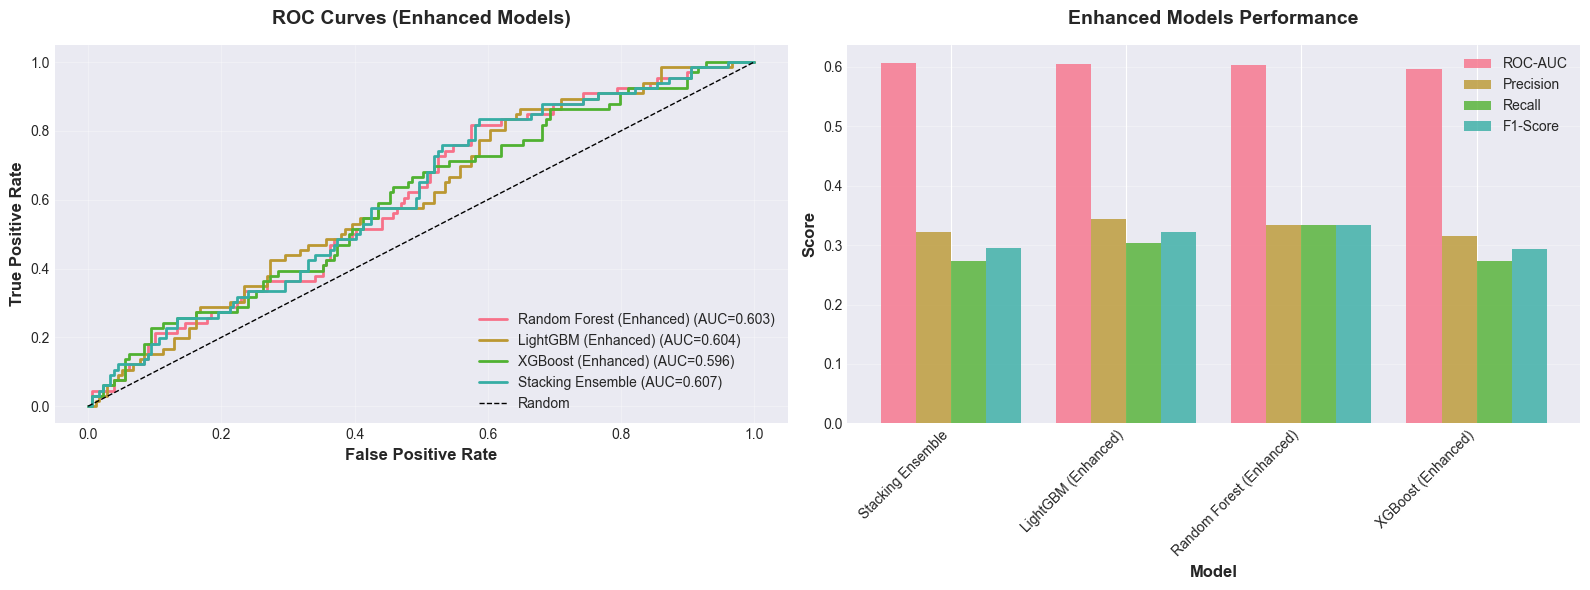

In [13]:
# ┌────────────────────────────────────────────────────────────┐
# │ Visualize Improvement                                      │
# └────────────────────────────────────────────────────────────┘

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curves
for i, results in enumerate(enhanced_results):
    fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba'])
    axes[0].plot(fpr, tpr, label=f"{results['model_name']} (AUC={results['roc_auc']:.3f})",
                linewidth=2)

axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[0].set_title('ROC Curves (Enhanced Models)', fontsize=14, fontweight='bold', pad=15)
axes[0].legend(loc='lower right')
axes[0].grid(alpha=0.3)

# Metric comparison
metrics = ['ROC-AUC', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(enhanced_df))
width = 0.2

for i, metric in enumerate(metrics):
    axes[1].bar(x + i*width, enhanced_df[metric], width, label=metric, alpha=0.8)

axes[1].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1].set_title('Enhanced Models Performance', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xticks(x + width * 1.5)
axes[1].set_xticklabels(enhanced_df['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(DIR_FIGURES / '25_enhanced_results.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 8. Export Final Model

╔════════════════════════════════════════════════════════════════╗
║                    EXPORT ENHANCED MODEL                        ║
╚════════════════════════════════════════════════════════════════╝

In [ ]:
# Select best model
best_idx = enhanced_df['ROC-AUC'].idxmax()
best_model_name = enhanced_df.loc[best_idx, 'Model']
best_model = enhanced_results[best_idx]['model']

# Save
with open(DIR_MODELS / 'best_churn_model_enhanced.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open(DIR_MODELS / 'feature_scaler_enhanced.pkl', 'wb') as f:
    pickle.dump(scaler, f)

import json
with open(DIR_MODELS / 'feature_names_enhanced.json', 'w') as f:
    json.dump(top_features, f, indent=2)

# Save results
enhanced_df.to_csv(DIR_RESULTS / 'outputs' / 'enhanced_model_comparison.csv', index=False)

print(f"✅ Best Model Saved: {best_model_name}")
print(f"   ROC-AUC: {enhanced_df.loc[best_idx, 'ROC-AUC']:.4f}")
print(f"   Features: {len(top_features)}")

print("\n" + "═"*80)
print("ENHANCEMENT COMPLETE")
print("═"*80)
print(f"\nImprovements Applied:")
print(f"  ✓ SMOTE oversampling")
print(f"  ✓ {X_enhanced.shape[1] - X.shape[1]} interaction features created")
print(f"  ✓ Feature selection: {X.shape[1]} → {len(top_features)}")
print(f"  ✓ Optimized hyperparameters")
print(f"  ✓ Ensemble stacking")
print(f"\nResult: {baseline_best:.4f} → {enhanced_best:.4f} (+{improvement:.4f})")
print("="*80)

✅ Best Model Saved: Stacking Ensemble
   ROC-AUC: 0.6067
   Features: 40

════════════════════════════════════════════════════════════════════════════════
ENHANCEMENT COMPLETE
════════════════════════════════════════════════════════════════════════════════

Improvements Applied:
  ✓ SMOTE oversampling
  ✓ 14 interaction features created
  ✓ Feature selection: 30 → 40
  ✓ Optimized hyperparameters
  ✓ Ensemble stacking

Result: 0.6423 → 0.6067 (+-0.0356)
